In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

 99% 1.97G/1.98G [00:30<00:00, 93.3MB/s]
100% 1.98G/1.98G [00:30<00:00, 68.9MB/s]


In [3]:
import zipfile
zip_ref= zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img,img_to_array
from PIL import Image

In [13]:
train_dir = Path('/content/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))


val_dir = Path('/content/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [28]:
def image_processing(filepath):
    labels = labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [29]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [31]:
print(len(train_df.Label.unique()))
print(train_df.Label.unique())

36
['capsicum' 'corn' 'chilli pepper' 'mango' 'cauliflower' 'beetroot'
 'tomato' 'peas' 'apple' 'kiwi' 'eggplant' 'ginger' 'onion' 'sweetcorn'
 'lettuce' 'paprika' 'grapes' 'cabbage' 'garlic' 'pineapple' 'cucumber'
 'watermelon' 'spinach' 'lemon' 'orange' 'raddish' 'carrot' 'sweetpotato'
 'jalepeno' 'turnip' 'pear' 'banana' 'pomegranate' 'potato' 'soy beans'
 'bell pepper']


In [32]:
train_df.head(5)

,Filepath,Label
0,/content/train/capsicum/Image_21.jpg,capsicum
1,/content/train/corn/Image_54.jpg,corn
2,/content/train/chilli pepper/Image_5.jpg,chilli pepper
3,/content/train/mango/Image_13.jpg,mango
4,/content/train/cauliflower/Image_20.jpg,cauliflower


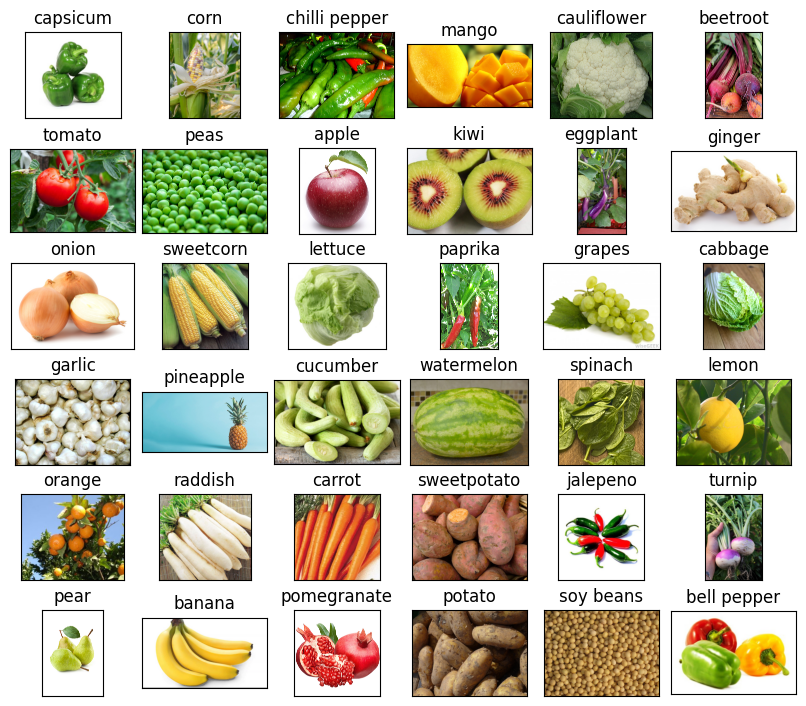

In [33]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [34]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [38]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [39]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [40]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
87/87 [==============================] - 84s 890ms/step - loss: 1.6875 - accuracy: 0.5532 - val_loss: 0.4271 - val_accuracy: 0.8743
Epoch 2/10
87/87 [==============================] - 85s 986ms/step - loss: 0.5721 - accuracy: 0.8176 - val_loss: 0.3009 - val_accuracy: 0.9012
Epoch 3/10
87/87 [==============================] - 78s 897ms/step - loss: 0.3274 - accuracy: 0.9022 - val_loss: 0.2103 - val_accuracy: 0.9461
Epoch 4/10
87/87 [==============================] - 89s 1s/step - loss: 0.2142 - accuracy: 0.9302 - val_loss: 0.2127 - val_accuracy: 0.9341
Epoch 5/10
87/87 [==============================] - 77s 886ms/step - loss: 0.1409 - accuracy: 0.9561 - val_loss: 0.1498 - val_accuracy: 0.9671
Epoch 6/10
87/87 [==============================] - 79s 916ms/step - loss: 0.1080 - accuracy: 0.9694 - val_loss: 0.1638 - val_accuracy: 0.9491
Epoch 7/10
87/87 [==============================] - 86s 998ms/step - loss: 0.0807 - accuracy: 0.9755 - val_loss: 0.1536 - val_accuracy: 0.9581


In [51]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [52]:
def check(img):
    image = Image.open(img)
    image = image.resize((224,224))
    img=img_to_array(image)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return image,res

1/1 [==============================] - 0s 22ms/step
Predicted tthing is:  carrot


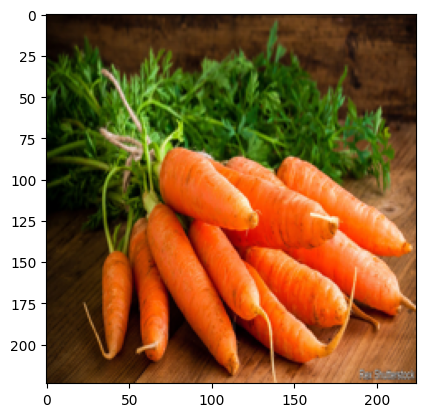

In [54]:
plot,prediction=check(r'/content/test/carrot/Image_1.jpg')
print("Predicted tthing is: ", prediction)
plt.imshow(plot)
plt.show()

1/1 [==============================] - 0s 44ms/step
Predicted tthing is:  mango


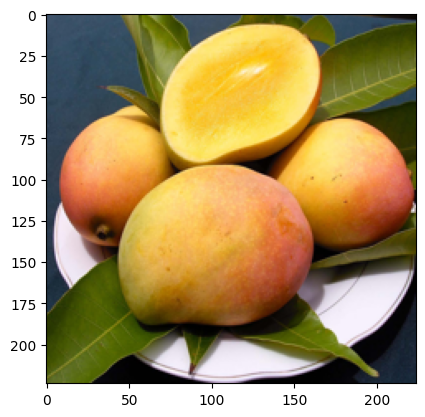

In [55]:
plot,prediction=check(r'/content/test/mango/Image_2.jpg')
print("Predicted tthing is: ", prediction)
plt.imshow(plot)
plt.show()

In [57]:
model.save('/content/class.h5')